# Scaling the Aussel 2018 equation
To match the Mazzoni 2015 amplitude scale in absolute terms.

In [41]:
import wslfp
import numpy as np
import matplotlib.pyplot as plt

In [42]:
import pandas as pd

df = pd.read_csv("mazzoni15-amp.csv")
f_orig = df.values[:, 1:]
d = df.values[:, 0]
r = df.columns[1:].astype(float) * 250
f_orig.shape, d, r

((32, 9),
 array([ 375.,  350.,  325.,  300.,  275.,  250.,  225.,  200.,  175.,
         150.,  125.,  100.,   75.,   50.,   25.,    0.,  -25.,  -50.,
         -75., -100., -125., -150., -175., -200., -225., -250., -275.,
        -300., -325., -350., -375., -400.]),
 Index([0.0, 125.0, 250.0, 375.0, 500.0, 625.0, 750.0, 875.0, 1000.0], dtype='float64'))

[Text(0.5, 1.0, 'Mazzoni 2015 amplitude (μV)'),
 Text(0, 0.5, 'Electrode depth (μm)'),
 Text(0.5, 0, 'Electrode lateral distance (μm)')]

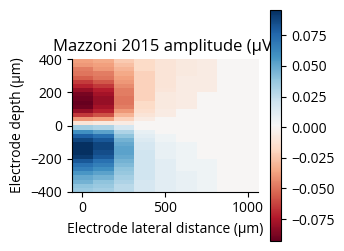

In [43]:
fig, ax = plt.subplots(figsize=(3, 3))
kwargs = dict(cmap="RdBu", extent=[-62.5, 1062.5, -400, 400])

im = ax.imshow(f_orig, **kwargs)
fig.colorbar(im)
ax.set(
    title=f"Mazzoni 2015 amplitude (μV)",
    ylabel="Electrode depth (μm)",
    xlabel="Electrode lateral distance (μm)",
)

In [44]:
rng = np.random.default_rng()

rr, dd = np.meshgrid(r, d)

# for plotting
rstep = np.diff(r).mean()
dstep = np.diff(d).mean()
extent = [
    rr.min() - rstep / 2,
    rr.max() + rstep / 2,
    dd.min() - dstep / 2,
    dd.max() + dstep / 2,
]

## Aussel et al., 2018 cosine approximation

/home/kyle/Dropbox (GaTech)/projects/wslfp/wslfp/amplitude.py:10: RuntimeWarning: invalid value encountered in divide
  costheta = -d_um / dist


(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Aussel 2018 amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

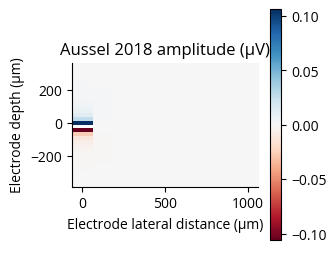

In [45]:
f_aussel = wslfp.aussel18(rr, dd)
wslfp.plot_amp(f_aussel, title="Aussel 2018 amplitude (μV)", extent=extent)

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Aussel 2018 population amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

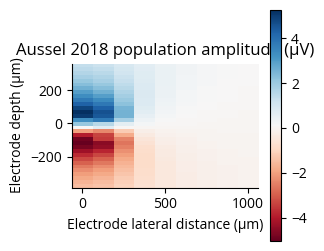

In [46]:
n = 40000
# center of neuron between -100 and 100 microns
nrns_somata = rng.uniform(-250, 0, n)
nrns_apex = rng.uniform(0, 250, n)
dd_neurons = (nrns_somata + nrns_apex) / 2
dd_pop = dd[..., np.newaxis] - dd_neurons
# neuron lengths between 100 and 400 microns
# L_pop = rng.uniform(100, 400, n)
L_pop = nrns_apex - nrns_somata
# horizontal distance: not simple. depends on r
rr_neurons = np.sqrt(rng.uniform(0, 250**2, n))
theta_neurons = rng.uniform(0, 2 * np.pi, n)
rr_pop = np.sqrt(
    (rr[..., np.newaxis] - rr_neurons * np.cos(theta_neurons)) ** 2
    + (rr_neurons * np.sin(theta_neurons)) ** 2
)

f_aussel_pop = wslfp.aussel18(rr_pop, dd_pop, L_pop).sum(axis=2) / n * 4000
wslfp.plot_amp(
    f_aussel_pop, title="Aussel 2018 population amplitude (μV)", extent=extent
)

Optimize scaling factor $A$:

$$ \tilde{f}(r, d) = A f(r, d) $$
$$ A = \argmin_A (f_{ML} - \tilde{f})^2 $$
$$ A = \argmin_A (f_{ML} - Af(r,d))^2 $$
$$ \vdots $$
$$ A = \frac{\sum_{i=1}^{N} f_{ML} f(r_i, d_i)}{\sum_{i=1}^{N} f(r_i, d_i)^2} $$


In [47]:
A = (f_aussel_pop * f_orig).sum() / (f_aussel_pop**2).sum()
A

0.021090785918217666

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Scaled Aussel 2018 population amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

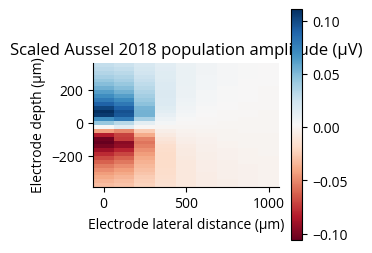

In [48]:
wslfp.plot_amp(
    A * f_aussel_pop,
    title="Scaled Aussel 2018 population amplitude (μV)",
    extent=extent,
)

Ok, running this a few times gives a consistent value of ~0.021 for $A$.